<a href="https://colab.research.google.com/github/kKn00077/techit-travel-data-analysis/blob/main/China_Douyin_Festival_Txtmining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 필요한 모듈 인스톨
# !pip install konlpy
# !pip install gdown

In [3]:
# 필요한 모듈 임포트
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
import re

In [7]:
import gdown

# 스프레드시트 ID
file_id = '1jANAoY6aSSG-nUTxVbpun1jWwwrva0VIQf74UsUSh1g'

# CSV 다운로드 링크 생성
download_url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=csv"

# 다운로드 파일명 지정
output = '241120_Douyin_Search_KorFestival.csv'

# 파일 다운로드
gdown.download(download_url, output, quiet=False)

df = pd.read_csv(output)
display(df.head(), df.shape)

Downloading...
From: https://docs.google.com/spreadsheets/d/1jANAoY6aSSG-nUTxVbpun1jWwwrva0VIQf74UsUSh1g/export?format=csv
To: /content/241120_Douyin_Search_KorFestival.csv
729kB [00:00, 11.5MB/s]


,no,keyword,keyword_ko,runtime,like,title,title_ko,channel,date
0,1,耽罗文化节,탐라문화제,0:39,99,#海外文化传播 #汉服小姐姐 #耽罗文化节 #文化自信,#해외 문화 전파 #한복 여성 #탐라문화제 #문화 자신감,@老城区归国华侨联合会,2024-10-05
1,2,耽罗文化节,탐라문화제,1:39,39,济州岛街头偶遇韩国隆重的耽罗文化节，氛围感很浓,제주도의 성대한 탐라문화제는 분위기가 아주 좋습니다.,@铃声,2024-10-05
2,3,耽罗文化节,탐라문화제,0,25,姐姐和小伙伴们参加韩国耽罗文化节，与多国艺术团共巡游，活动圆满成功！#五指山黎苗童声合唱团#...,한국에서 열린 탐라문화제에서 다국적 예술단과 함께 퍼레이드를 펼치며 성황리에 행사를...,@尤然🎶-回村的小李-水满乡新村（苗寨）,2024-10-08
3,4,耽罗文化节,탐라문화제,0:31,1131,赴韩演出！洛职师生出国开展文艺交流，惊艳亮相韩国耽罗文化艺术节！（来源：戏曲艺术学院）#洛阳...,한국에서의 공연! 낙양직업기술대학의 교사와 학생들이 문화교류를 위해 해외로 나가 한...,@洛阳职业技术学院,2024-10-06
4,5,耽罗文化节,탐라문화제,1:35,26,华流才是顶流！洛阳艺术家代表团：韩国济州第62届耽罗文化节，我们来啦！着我汉家衣冠华裳，非遗...,한류는 최고의 흐름입니다! 뤄양 예술단: 대한민국 제주에서 열리는 제62회 탐라문화...,@老城区归国华侨联合会,2023-10-09


(1477, 9)

In [11]:
display(df['keyword_ko'].value_counts().sort_values(ascending=False))

,count
keyword_ko,
서울세계불꽃축제,226
보령머드축제,225
화천산천어축제,144
탐라문화제,133
부평풍물대축제,131
수원화성문화제,131
대전0시축제,128
여주오곡나루축제,121
소래포구축제,120


In [9]:
# 2024년 축제 기간 정리
festival = {
    'keyword_ko': [
        '탐라문화제', '서울세계불꽃축제', '보령머드축제', '여주오곡나루축제',
        '소래포구축제', '대전0시축제', '광주김치축제', '부평풍물대축제',
        '화천산천어축제', '수원화성문화제'
    ],
    'place': [
        '제주도 제주시', '서울 여의도 한강공원', '충청남도 보령시 대천해수욕장',
        '경기도 여주시 신륵사 관광지', '인천 남동구 소래포구 해오름광장',
        '대전 중앙로', '광주광역시청 광장', '인천 부평구', '강원도 화천군',
        '경기도 수원시 수원화성'
    ],
    'start_date': [
        '2024-10-05', '2024-10-05', '2024-07-19', '2024-10-18', '2024-09-27',
        '2024-08-09', '2024-10-18', '2024-09-27', '2024-01-06', '2024-10-04'
    ],
    'end_date': [
        '2024-10-09', '2024-10-05', '2024-08-04', '2024-10-20', '2024-09-29',
        '2024-08-17', '2024-10-20', '2024-09-29', '2024-01-28', '2024-10-06'
    ]
}

# 데이터프레임 생성
festival = pd.DataFrame(festival)

# '시작일'과 '종료일'을 datetime 형식으로 변환
festival['start_date'] = pd.to_datetime(festival['start_date'])
festival['end_date'] = pd.to_datetime(festival['end_date'])

# 축제 기간 계산 (종료일 - 시작일 + 1일)
festival['period'] = (festival['end_date'] - festival['start_date']).dt.days + 1

# 데이터프레임 출력
display(festival)

,keyword_ko,place,start_date,end_date,period
0,탐라문화제,제주도 제주시,2024-10-05,2024-10-09,5
1,서울세계불꽃축제,서울 여의도 한강공원,2024-10-05,2024-10-05,1
2,보령머드축제,충청남도 보령시 대천해수욕장,2024-07-19,2024-08-04,17
3,여주오곡나루축제,경기도 여주시 신륵사 관광지,2024-10-18,2024-10-20,3
4,소래포구축제,인천 남동구 소래포구 해오름광장,2024-09-27,2024-09-29,3
5,대전0시축제,대전 중앙로,2024-08-09,2024-08-17,9
6,광주김치축제,광주광역시청 광장,2024-10-18,2024-10-20,3
7,부평풍물대축제,인천 부평구,2024-09-27,2024-09-29,3
8,화천산천어축제,강원도 화천군,2024-01-06,2024-01-28,23
9,수원화성문화제,경기도 수원시 수원화성,2024-10-04,2024-10-06,3


In [12]:
# festival의 start_date보다 7일이전부터
# end_date보다 7일이후까지만 df에서 필터링해 새로운 df_clean 데이터프레임 만들기

# df['date'] 날짜타입으로 변환
df['date'] = pd.to_datetime(df['date'])

# 빈 데이터프레임 생성
df_clean = pd.DataFrame()

# 날짜연산을 위한 timedelta 모듈 불러오기
from datetime import timedelta

# festival 데이터프레임의 각 행에 대해 반복
for _, row in festival.iterrows():
    keyword = row['keyword_ko']
    start_date = pd.to_datetime(row['start_date']) - timedelta(days=7)
    end_date = pd.to_datetime(row['end_date']) + timedelta(days=7)

    # 해당 기간과 키워드에 해당하는 데이터 필터링
    mask = (df['keyword_ko'] == keyword) & (df['date'] >= start_date) & (df['date'] <= end_date)
    filtered_df = df[mask]

    # 필터링된 데이터를 df_clean에 추가
    df_clean = pd.concat([df_clean, filtered_df], ignore_index=True)

# 출력
display(df_clean.shape)
display(df_clean['keyword_ko'].value_counts().sort_values(ascending=False))

(245, 9)

,count
keyword_ko,
서울세계불꽃축제,97
보령머드축제,49
대전0시축제,23
화천산천어축제,23
탐라문화제,17
소래포구축제,9
광주김치축제,7
부평풍물대축제,7
수원화성문화제,7


In [34]:
# 축제별 like수 합산
like_sum_by_keyword = df_clean.groupby('keyword_ko')['like'].sum().reset_index().sort_values(by='like', ascending=False)
display(like_sum_by_keyword)

,keyword_ko,like
9,화천산천어축제,120686
4,서울세계불꽃축제,86927
2,보령머드축제,14111
8,탐라문화제,5713
7,여주오곡나루축제,2148
1,대전0시축제,891
5,소래포구축제,649
3,부평풍물대축제,514
6,수원화성문화제,478
0,광주김치축제,294


 [[트렌드트립#5] 방한외래객 인기 축제 트렌드 분석](https://datalab.visitkorea.or.kr/site/portal/ex/bbs/View.do?cbIdx=1129&bcIdx=308262&pageIndex=1&cateCont=tlt03) <br>
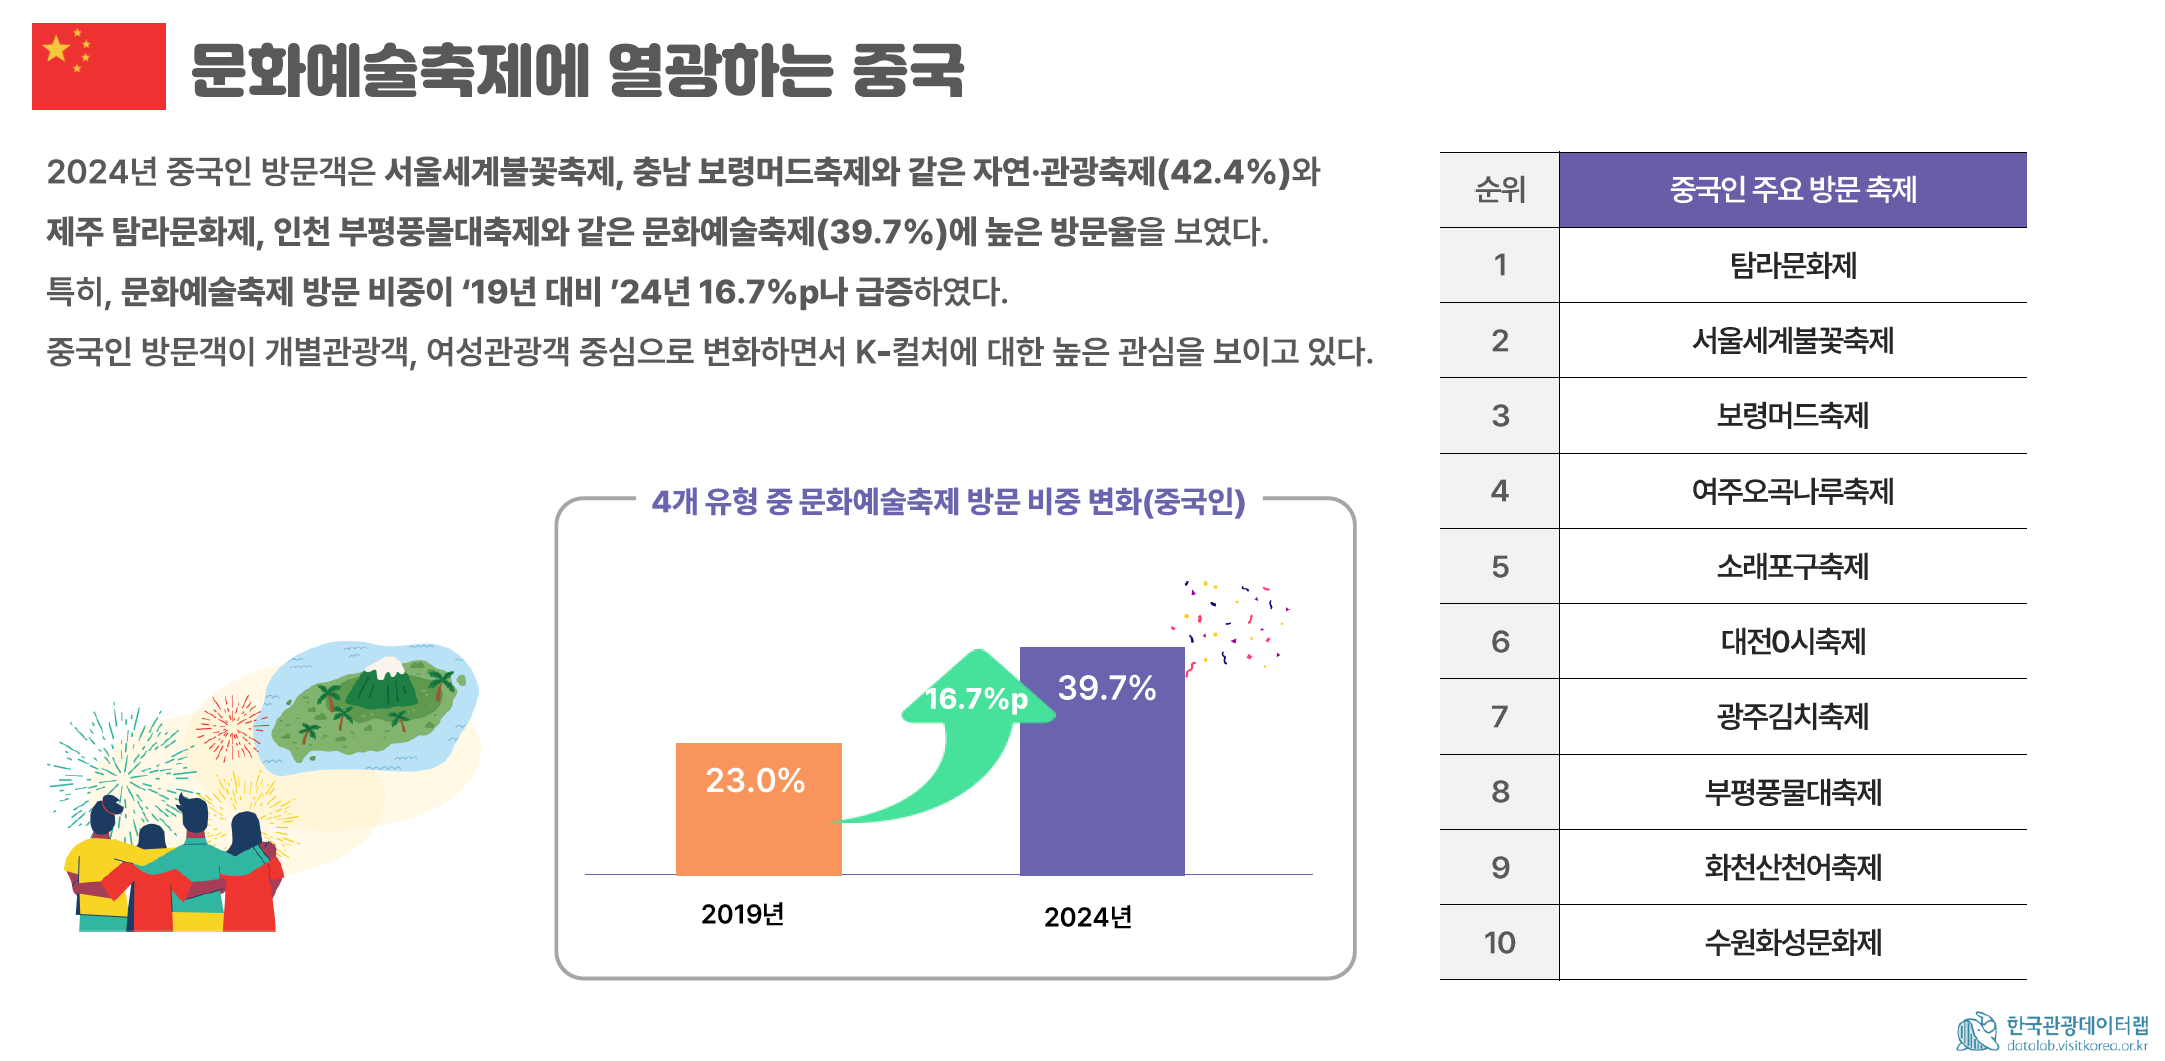

* 한국관광데이터랩의 데이터는 KT이동통신 빅데이터로 <br>
방문 목적을 명확히 알 수 없는 빅데이터 한계상, 지역 축제 방문객과 축제장 인근 방문객을 구분하기 어렵다고 명시되어 있음 <br>
* 더우인 SNS 상에서는 1)서울세계불꽃축제-2)보령머드축제-3)대전0시축제/화천산천어축제 순으로 관심도가 높은 것으로 나타남

In [13]:
# 전처리(1) : 이모티콘, 특수문자 제거

import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

okt = Okt()

# 이모티콘, 특수문자 제거
def preprocess(text):
    # 이모티콘, 유니코드 범위 및 특수 문자를 제거하는 정규식 (숫자는 제외)
    emoji_pattern = re.compile(
        r"["
        r"\U0001F600-\U0001F64F"  # 이모티콘 범위 (유니코드)
        r"\U0001F300-\U0001F5FF"  # 기호 및 아이콘
        r"\U0001F680-\U0001F6FF"  # 운송 및 기계 관련 유니코드
        r"\U0001F700-\U0001F77F"  # 기타 유니코드 기호
        r"\U0001F780-\U0001F7FF"  # 추가 유니코드 기호
        r"\U0001F800-\U0001F8FF"  # 유니코드 기술 문자
        r"\U0001F900-\U0001F9FF"  # 제스처와 감정 관련 이모티콘
        r"\U0001FA00-\U0001FA6F"  # 이모티콘 확장
        r"\U0001FB00-\U0001FBFF"  # 추가 확장 이모티콘
        r"\u2600-\u26FF"          # 기호 및 도형 (예: ♠, ♣)
        r"\u2700-\u27BF"          # 기타 기호 (예: ✨, ✋)
        r"]+",
        flags=re.UNICODE
    )

    # 정규식을 이용해 매칭되는 문자 제거
    return emoji_pattern.sub(r'', str(text))

# 모든 텍스트에 대해 전처리 적용
df_clean['processed_title_ko'] = df_clean['title_ko'].apply(preprocess)

In [14]:
# 전처리(2) : 유사 단어 치환, 명사, 용언 추출, 불용어 처리

# 유사 단어 치환
replace_dict = {
    "서울특별시": "서울",
    "수도" : "서울",
    "부산광역시": "부산",
    "경기도" : "경기",
    "제주도": "제주",
    "강원도" : "강원",
    "인천광역시" : "인천"
    # 필요한 만큼 추가
}

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if word in replace_dict :
          word = replace_dict[word]

        if tag == 'Noun' and len(word) > 1:  # 명사
            result.append(word)

        elif tag in ['Verb', 'Adjective']:   # 용언(동사, 형용사)
            if not word.endswith('다'):      # 이미 "다"로 끝나지 않으면 추가
                word += '다'
            result.append(word)

    return result

# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출
all_words = []
for text in df_clean['processed_title_ko']:  # 'processed_title_ko'는 텍스트가 포함된 컬럼 이름
    all_words.extend(preprocess_text(text))

# 단어 빈도 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환
df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다", "갈다",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드"]  # 커스텀 불용어 리스트
df_word = df_word[~df_word['word'].isin(stop_words)]

# 상위 50개 단어를 빈도순으로 정렬하여 출력
df_word_sorted = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_word_sorted.head(50)

,word,freq
0,축제,126
1,불꽃,90
2,서울,58
3,머드,41
4,얼음,31
5,세계,30
6,문화,25
7,페스티벌,21
8,공연,21
9,난징,20


In [16]:
# 구글 코렙에서 워드클라우드를 위한 폰트 설치
# !sudo apt-get install -y fonts-noto-cjk

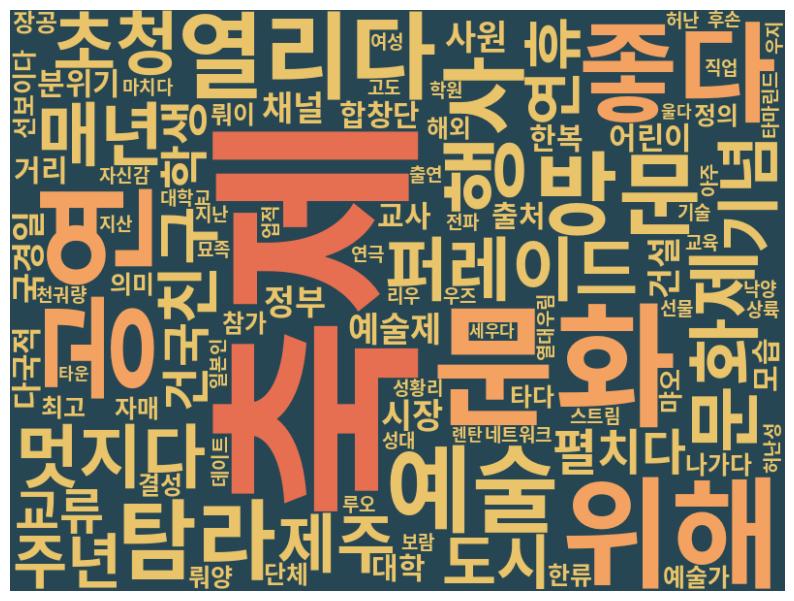

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (코랩에서 설치한 경우)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'

# 상위 100개 데이터 사용
top_words = df_word.head(100)

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = df_word.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 설정
    background_color='#264653',  # 배경색
    width=800,
    height=600,
    min_font_size=4,             # 최소 글자 크기
    color_func=color_func        # 색상 함수
).generate_from_frequencies(dict(top_words.values))

# 워드클라우드 출력
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
# 1. 서울세계불꽃축제 분석
# '불꽃'이 들어간 title_ko 검색
keyword = "불꽃"

# keyword로 필터링된 데이터
keyword_df = df_clean[df_clean['title_ko'].str.contains(keyword, na=False)]
display(keyword_df)

,no,keyword,keyword_ko,runtime,like,title,title_ko,channel,date,processed_title_ko
17,135,首尔世界烟花庆典,서울세계불꽃축제,0:20,208,2024年10月5日首尔烟花大会即将开始，每一年世界各地的游客欢聚于此，今年也不例外，但今年...,2024년 10월 5일 개막을 앞둔 서울세계불꽃축제는 매년 전 세계 관람객들이 모여...,@首尔有个老板娘,2024-10-03,2024년 10월 5일 개막을 앞둔 서울세계불꽃축제는 매년 전 세계 관람객들이 모여...
18,137,首尔世界烟花庆典,서울세계불꽃축제,0:30,21000,🇰🇷赶上首尔一年一度的世界烟花庆典～ 出乎意料的震撼🤩❣️ #首尔 #韩国烟花节 #首尔烟花节,🇰🇷 서울의 연례 세계불꽃축제를 만나보세요~ 의외로 멋진 🤩❣️ #서울 #대한민국불...,@Tonight,2024-10-06,🇰🇷 서울의 연례 세계불꽃축제를 만나보세요~ 의외로 멋진 ️ #서울 #대한민국불꽃축...
19,138,首尔世界烟花庆典,서울세계불꽃축제,0:12,5,2024首尔世界烟花庆典 Seoul World Fireworks Show #烟花最浪漫...,2024 서울세계불꽃축제 서울세계불꽃쇼 #불꽃의 가장 로맨틱한 순간,@Taoer .,2024-10-06,2024 서울세계불꽃축제 서울세계불꽃쇼 #불꽃의 가장 로맨틱한 순간
20,140,首尔世界烟花庆典,서울세계불꽃축제,0:53,0,2024首尔世界烟花节开幕 2864,2024 서울세계불꽃축제 개막 2864,@🇨🇳繁花小院,2024-10-07,2024 서울세계불꽃축제 개막 2864
21,141,首尔世界烟花庆典,서울세계불꽃축제,0:21,24,来自100万人的呐喊声，首尔世界烟花节20周年#首尔烟花节 #这就是放烟花的仪式感 #那一瞬...,"백만명의 함성, 서울세계불꽃축제 20주년 #서울세계불꽃축제 #불꽃을 터트리는 의식 ...",@在韩华人滑雪俱乐部,2024-10-05,"백만명의 함성, 서울세계불꽃축제 20주년 #서울세계불꽃축제 #불꽃을 터트리는 의식 ..."
...,...,...,...,...,...,...,...,...,...,...
111,349,首尔世界烟花庆典,서울세계불꽃축제,1:13,14,这pa不错 #国际烟花节 #首尔 #韩国留学 @DOU+小助手 @DOU+上热门,이빠가좋아 #국제불꽃축제 #서울 #한국유학 @DOU+작은조수 @DOU+온트렌드,@shin지유,2024-10-07,이빠가좋아 #국제불꽃축제 #서울 #한국유학 @DOU+작은조수 @DOU+온트렌드
112,353,首尔世界烟花庆典,서울세계불꽃축제,0:22,5008,今晚首尔的夜太燃了，还是没忍住想和你分享... #首尔烟花节,"오늘 밤 서울의 밤은 너무 아름다웠지만, 여러분과 함께 나누지 않을 수 없었습니다....",@我叫西木慧,2024-10-05,"오늘 밤 서울의 밤은 너무 아름다웠지만, 여러분과 함께 나누지 않을 수 없었습니다...."
113,354,首尔世界烟花庆典,서울세계불꽃축제,0:20,600,汉江烟花节 韩国人提前一天就来占位置. #汉江世界烟花节 #烟花秀 #人山人海人挤人 #偶遇...,한강 불꽃축제 한국인들이 하루 일찍 와서 자리를 잡았습니다. #한강세계불꽃축제 #불...,@首尔有个老板娘,2024-10-05,한강 불꽃축제 한국인들이 하루 일찍 와서 자리를 잡았습니다. #한강세계불꽃축제 #불...
115,361,保宁泥浆节,보령머드축제,0,7,🇰🇷保宁美容泥浆节开始啦～2024 保宁泥浆节｜外岩民俗村 * 保宁泥浆节，是韩国最具代表性...,🇰🇷 보령 머드축제가 시작되었습니다 ~ 2024 보령머드축제｜와암민속마을 * 대한민...,@KBCS韩系生活,2024-07-26,🇰🇷 보령 머드축제가 시작되었습니다 ~ 2024 보령머드축제｜와암민속마을 * 대한민...


In [22]:
# 유사 단어 치환
replace_dict = {
    "서울특별시": "서울",
    "수도" : "서울",
    "부산광역시": "부산",
    "경기도" : "경기",
    "제주도": "제주",
    "강원도" : "강원",
    "인천광역시" : "인천"
    # 필요한 만큼 추가
}

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if word in replace_dict :
          word = replace_dict[word]

        if tag == 'Noun' and len(word) > 1:  # 명사
            result.append(word)

        elif tag in ['Verb', 'Adjective']:   # 용언(동사, 형용사)
            if not word.endswith('다'):      # 이미 "다"로 끝나지 않으면 추가
                word += '다'
            result.append(word)

    return result

# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출
all_words = []
for text in keyword_df['processed_title_ko']:  # 'processed_title_ko'는 텍스트가 포함된 컬럼 이름
    all_words.extend(preprocess_text(text))

# 단어 빈도 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환
df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다", "갈다",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드",
              "서울", "부산", "제주", "경기", "제주", "강원", "인천",
              "세계", "국제", "불꽃", "축제", "불꽃놀이"]  # 커스텀 불용어 리스트
df_word = df_word[~df_word['word'].isin(stop_words)]

# 상위 50개 단어를 빈도순으로 정렬하여 출력
df_word_sorted = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_word_sorted.head(50)

,word,freq
0,아름답다,14
1,소원,14
2,머드,13
3,순간,8
4,빌다,8
5,보령,8
6,보고,7
7,사랑,6
8,드리다,6
9,보내다,6


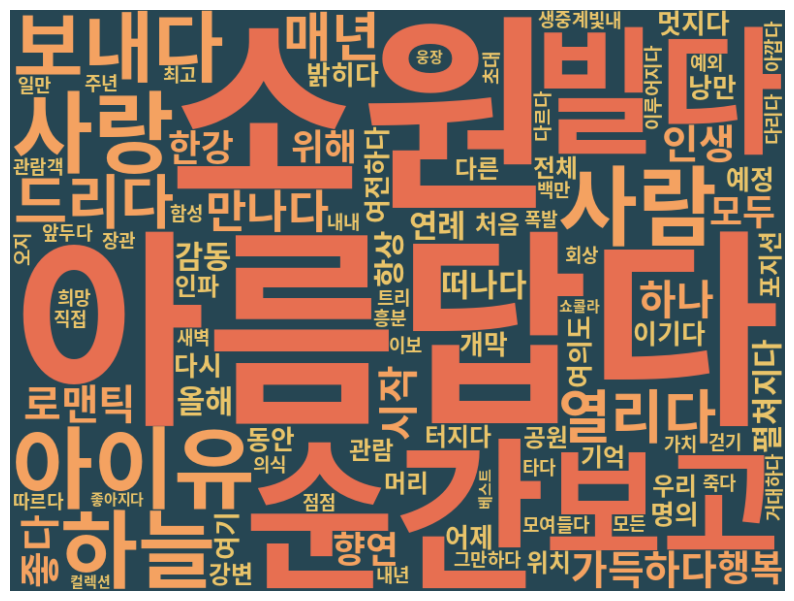

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (코랩에서 설치한 경우)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'

# 상위 100개 데이터 사용
top_words = df_word.head(100)

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = df_word.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 설정
    background_color='#264653',  # 배경색
    width=800,
    height=600,
    min_font_size=4,             # 최소 글자 크기
    color_func=color_func        # 색상 함수
).generate_from_frequencies(dict(top_words.values))

# 워드클라우드 출력
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* 서울세계불꽃축제의 불꽃만 텍스트마이닝했을 경우, '아름답다', '소원', '빌다'라는 단어가 최상위권으로 나왔다. <br>
** 서울세계불꽃축제는 2024년10월05일(토)에 열렸는데, 마침 중국의 국경절로서 10월1일(화)부터 10월7일(월)까지 총 7일의 연휴가 주어지는 휴가기간이었다. <br>
** 중국의 휴가기간에 축제를 여는 것은 중국 관광객의 한국 관광 유치에 상당히 바람직해 보인다!

In [24]:
# 2. 보령머드축제 분석
# '머드'가 들어간 title_ko 검색
keyword = "머드"

# keyword로 필터링된 데이터
keyword_df = df_clean[df_clean['title_ko'].str.contains(keyword, na=False)]
display(keyword_df)

,no,keyword,keyword_ko,runtime,like,title,title_ko,channel,date,processed_title_ko
114,360,保宁泥浆节,보령머드축제,1:52,83,我在韩国玩泥巴！夏日泥浆大狂欢 #韩国旅游 #韩国日常 #旅行vlog #海外生活 #保宁泥浆节,한국에서 머드와 놀아요! 여름머드배쉬 #한국관광 #한국일상 #여행 브이로그 #해외생...,@文大志在韩国,2024-07-30,한국에서 머드와 놀아요! 여름머드배쉬 #한국관광 #한국일상 #여행 브이로그 #해외생...
115,361,保宁泥浆节,보령머드축제,0,7,🇰🇷保宁美容泥浆节开始啦～2024 保宁泥浆节｜外岩民俗村 * 保宁泥浆节，是韩国最具代表性...,🇰🇷 보령 머드축제가 시작되었습니다 ~ 2024 보령머드축제｜와암민속마을 * 대한민...,@KBCS韩系生活,2024-07-26,🇰🇷 보령 머드축제가 시작되었습니다 ~ 2024 보령머드축제｜와암민속마을 * 대한민...
116,364,保宁泥浆节,보령머드축제,0,123,保宁泥浆节#ricky #撕漫男 #舞台,폴린 머드페스트 #리키 #리프만화인 #무대,@mini,2024-08-04,폴린 머드페스트 #리키 #리프만화인 #무대
117,367,保宁泥浆节,보령머드축제,3:35,6,保宁泥浆节-After School#Zoa #赵慧洹 #Weeekly #AfterSchool,폴린 머드 페스티벌 - 애프터스쿨 #조아 #자오후이환 #주간 #애프터스쿨,@OnlyFor_Zoa赵慧洹,2024-07-21,폴린 머드 페스티벌 - 애프터스쿨 #조아 #자오후이환 #주간 #애프터스쿨
118,368,保宁泥浆节,보령머드축제,0,23,保宁塞泥浆音乐🎶节。水很给力就是孩子唔得有点紧🤣#zb1 #章昊c位 #向全世界安利 #无法...,파울리네 머드 뮤직 🎶 페스티벌. 물은 매우 강력하지만 아이들이 조금 빡빡해서 🤣 ...,@活久见大仙女,2024-08-04,파울리네 머드 뮤직 페스티벌. 물은 매우 강력하지만 아이들이 조금 빡빡해서 #z...
119,369,保宁泥浆节,보령머드축제,0,101,你就像艺术品 保宁泥浆音乐节©S2ovemorenow#成韩彬 #zb1 #韩娱 #kpop...,당신은 예술 작품 같은 폴린 머드 페스티벌 ©S2ovemorenow #성한빈 #zb...,@beeeny,2024-08-03,당신은 예술 작품 같은 폴린 머드 페스티벌 ©S2ovemorenow #성한빈 #zb...
120,377,保宁泥浆节,보령머드축제,1:00,319,泼水节 掌管水枪的神！#沈泉锐 #ricky #zb1 #舞台 #保宁泥浆节 @DOU+小助...,물 축제 물총을 담당하는 신! #쉔취안루이 #리키 #zb1 #무대 #바오닝머드축제 ...,@记忆7minute.,2024-08-03,물 축제 물총을 담당하는 신! #쉔취안루이 #리키 #zb1 #무대 #바오닝머드축제 ...
121,378,保宁泥浆节,보령머드축제,0:14,2159,#沈泉锐 #沈泉锐ricky #ricky 今天晚上的保宁泥浆节，锐宝宝真的好帅#细腰,"#션콴루이 #션콴루이 리키 #리키 오늘 밤 보웬 머드 축제, 아기 루이 진짜 잘생겼...",@莓猫瑞奇,2024-08-03,"#션콴루이 #션콴루이 리키 #리키 오늘 밤 보웬 머드 축제, 아기 루이 진짜 잘생겼..."
122,379,保宁泥浆节,보령머드축제,0:21,112,保宁泥浆节，已被帅晕，我人没了#zerobaseone #沈泉锐ricky #沈泉锐 #向全...,"폴린머드축제, 벌써 잘생김에 기절, 사람이 다 떨어졌어요 #제로베이스원 #쉔콴루이리...",@ZHOU昼,2024-08-03,"폴린머드축제, 벌써 잘생김에 기절, 사람이 다 떨어졌어요 #제로베이스원 #쉔콴루이리..."
123,381,保宁泥浆节,보령머드축제,0:07,159,#沈泉锐ricky #保宁泥浆节,#쉔취안루이 리키 #보닌 머드 축제,@ris👅,2024-08-04,#쉔취안루이 리키 #보닌 머드 축제


In [29]:
# 유사 단어 치환
replace_dict = {
    "서울특별시": "서울",
    "수도" : "서울",
    "부산광역시": "부산",
    "경기도" : "경기",
    "제주도": "제주",
    "강원도" : "강원",
    "인천광역시" : "인천",
    "워터마크" : "워터파크"
    # 필요한 만큼 추가
}

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if word in replace_dict :
          word = replace_dict[word]

        if tag == 'Noun' and len(word) > 1:  # 명사
            result.append(word)

        elif tag in ['Verb', 'Adjective']:   # 용언(동사, 형용사)
            if not word.endswith('다'):      # 이미 "다"로 끝나지 않으면 추가
                word += '다'
            result.append(word)

    return result

# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출
all_words = []
for text in keyword_df['processed_title_ko']:  # 'processed_title_ko'는 텍스트가 포함된 컬럼 이름
    all_words.extend(preprocess_text(text))

# 단어 빈도 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환
df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다", "갈다",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드",
              "서울", "부산", "제주", "경기", "제주", "강원", "인천",
              "보령", "폴린", "보웬", "머드", "축제", "페스티벌"]  # 커스텀 불용어 리스트
df_word = df_word[~df_word['word'].isin(stop_words)]

# 상위 50개 단어를 빈도순으로 정렬하여 출력
df_word_sorted = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_word_sorted.head(50)

,word,freq
0,여름,10
1,워터파크,6
2,열리다,5
3,구역,4
4,리키,4
5,즐기다,4
6,체험,4
7,젖다,4
8,하나,4
9,민속,4


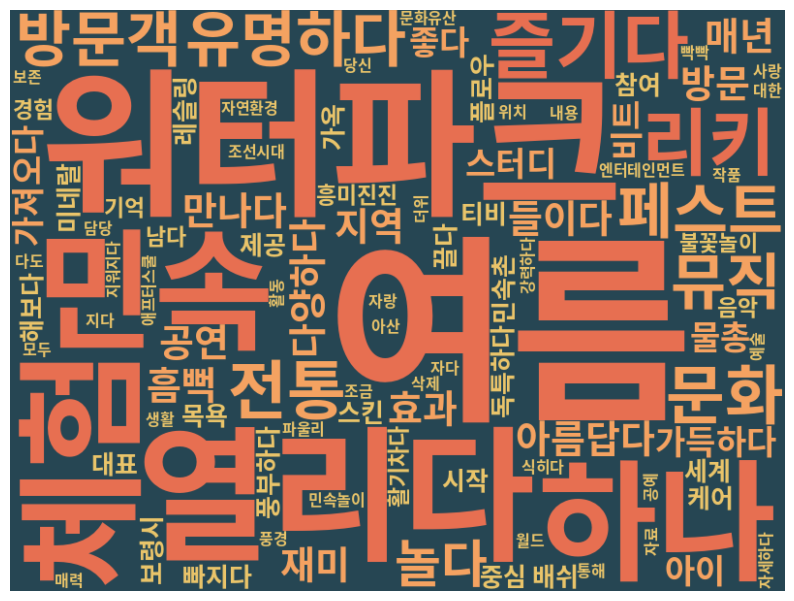

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (코랩에서 설치한 경우)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'

# 상위 100개 데이터 사용
top_words = df_word.head(100)

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = df_word.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 설정
    background_color='#264653',  # 배경색
    width=800,
    height=600,
    min_font_size=4,             # 최소 글자 크기
    color_func=color_func        # 색상 함수
).generate_from_frequencies(dict(top_words.values))

# 워드클라우드 출력
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* 보령머드축제의 머드만 텍스트마이닝했을 경우, '여름', '워터파크', '체험'이라는 단어가 최상위권으로 나왔다. <BR>
** 이외에도 '뮤직', 가수 이름인 '리키', '장하오'등이 등장하는데 포세이돈 워터 뮤직 페스티벌의 관심도가 높았던 것을 알 수 있다. <BR>
** '민속', '민속촌', '민속놀이', '전통'등의 단어들도 빈도가 있는 것으로 보아 민속체험도 기억에 남는 활동이었던 것으로 보인다.

In [35]:
# 3. 화천산천어축제 분석
# '산천어'가 들어간 title_ko 검색
keyword = "산천어"

# keyword로 필터링된 데이터
keyword_df = df_clean[df_clean['title_ko'].str.contains(keyword, na=False)]
display(keyword_df)

,no,keyword,keyword_ko,runtime,like,title,title_ko,channel,date,processed_title_ko
216,1209,华川山鳟鱼节,화천산천어축제,0:08,22,韩国华川山鳟鱼庆典开幕 首日游客超10万人,"화천 산천어축제, 첫날 10만여 명 방문...개막 첫날부터 인산인해",@Hi永嘉,2024-01-11,"화천 산천어축제, 첫날 10만여 명 방문...개막 첫날부터 인산인해"
217,1210,华川山鳟鱼节,화천산천어축제,0:36,23,韩国华川山鳟鱼庆典开幕 冰钓活动一票难求#鳟鱼,"대한민국 화천 산천어축제, 보기 힘든 얼음낚시 이벤트 #산천어와 함께 개막",@央视网产业,2024-01-08,"대한민국 화천 산천어축제, 보기 힘든 얼음낚시 이벤트 #산천어와 함께 개막"
219,1216,华川山鳟鱼节,화천산천어축제,0:53,121,对活动MC的事实暴击 毒舌#金熙栽 不会放过任何人 饭拍 240106华川鳟鱼节开幕式 @ ...,"행사 MC에 대한 팩트폭격, 독한 #김희재는 누구도 놓치지 않습니다 240106 화...",@voice of raining,2024-01-08,"행사 MC에 대한 팩트폭격, 독한 #김희재는 누구도 놓치지 않습니다 240106 화..."
233,1238,华川山鳟鱼节,화천산천어축제,2:46,23,来🇰🇷体验在冰上面钓鱼🔥100%有鱼上钩🫣 来🇰🇷体验在冰上面钓鱼🔥100%有鱼上钩🫣 冬季...,"얼음 위에서 즐기는 얼음낚시 체험, 🇰🇷 에 오세요 🔥 100% 입질 100% 🫣 ...",@小马总,2024-01-31,"얼음 위에서 즐기는 얼음낚시 체험, 🇰🇷 에 오세요 100% 입질 100% 🫣 얼..."
235,1245,华川山鳟鱼节,화천산천어축제,1:12,18,#韩国江原道 华川郡산천어축제#冰钓 #滑冰 #欢乐时光,대한민국 #강원도화천군산천어축제 #얼음낚시 #얼음스케이트 #해피아워,@金伟峰在韩国,2024-01-08,대한민국 #강원도화천군산천어축제 #얼음낚시 #얼음스케이트 #해피아워


In [36]:
# 유사 단어 치환
replace_dict = {
    "서울특별시": "서울",
    "수도" : "서울",
    "부산광역시": "부산",
    "경기도" : "경기",
    "제주도": "제주",
    "강원도" : "강원",
    "인천광역시" : "인천",
    "워터마크" : "워터파크"
    # 필요한 만큼 추가
}

# 텍스트 전처리 및 명사, 용언 추출 함수 정의
def preprocess_text(text):
    # NaN이나 float 값을 처리하기 위해 문자열로 변환
    if isinstance(text, float):
        return []

    # 형태소 분석
    pos = okt.pos(text, norm=True, stem=True)

    # 명사와 용언만 필터링
    result = []

    for word, tag in pos:
        if word in replace_dict :
          word = replace_dict[word]

        if tag == 'Noun' and len(word) > 1:  # 명사
            result.append(word)

        elif tag in ['Verb', 'Adjective']:   # 용언(동사, 형용사)
            if not word.endswith('다'):      # 이미 "다"로 끝나지 않으면 추가
                word += '다'
            result.append(word)

    return result

# 모든 텍스트 데이터를 하나로 결합 후, 명사 및 용언 추출
all_words = []
for text in keyword_df['processed_title_ko']:  # 'processed_title_ko'는 텍스트가 포함된 컬럼 이름
    all_words.extend(preprocess_text(text))

# 단어 빈도 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환
df_word = pd.DataFrame(word_counts.items(), columns=['word', 'freq'])

# 불용어 처리
stop_words = ["가다", "이다", "오다", "하다", "보다", "만들다", "없다", "있다", "되어다", "가보다", "갈다",
              "아니다", "않다", "되다", "같다", "알다", "모르다", "생각", "싶다", "나오다",
              "보이다", "이렇다", "많다", "그렇다", "진짜", "정말", "가장", "정도",  "매우",
              "한국", "대한민국", "여행", "한국여행", "브이", "로그", "마을", "추천", "명소", "투어", "관광", "가이드",
              "서울", "부산", "제주", "경기", "제주", "강원", "인천",
              "화천", "산천어", "축제"]  # 커스텀 불용어 리스트
df_word = df_word[~df_word['word'].isin(stop_words)]

# 상위 50개 단어를 빈도순으로 정렬하여 출력
df_word_sorted = df_word.sort_values(by='freq', ascending=False).reset_index(drop=True)
df_word_sorted.head(50)

,word,freq
0,얼음,10
1,관객,7
2,김희재,4
3,낚시,4
4,강조,4
5,오르다,3
6,진지하다,3
7,무대,3
8,즐기다,3
9,감정,2


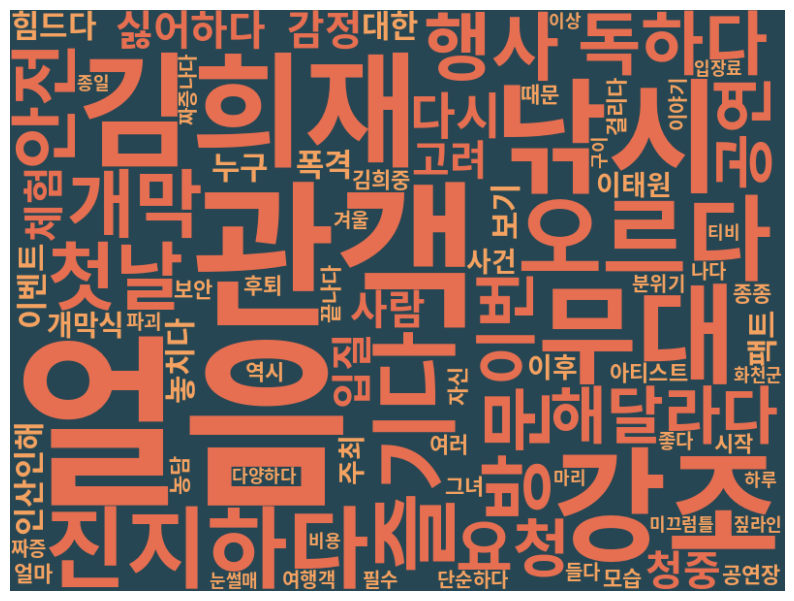

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (코랩에서 설치한 경우)
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'

# 상위 100개 데이터 사용
top_words = df_word.head(100)

# 빈도에 따른 색상 설정
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    freq = df_word.set_index('word').at[word, 'freq'] / df_word['freq'].sum()
    if freq > 0.01:
        return '#e76f51'
    elif freq > 0.005:
        return '#f4a261'
    else:
        return '#e9c46a'

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,          # 한글 폰트 경로 설정
    background_color='#264653',  # 배경색
    width=800,
    height=600,
    min_font_size=4,             # 최소 글자 크기
    color_func=color_func        # 색상 함수
).generate_from_frequencies(dict(top_words.values))

# 워드클라우드 출력
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
# 화천산천어축제에 like가 많은 이유는 뭘까?
# '화천산천어축제'로 필터링
filtered_df = df_clean[df_clean['keyword_ko'] == '화천산천어축제']

# 'like' 수로 내림차순 정렬
sorted_df = filtered_df.sort_values(by='like', ascending=False).reset_index(drop=True)

display(sorted_df.head(10))

,no,keyword,keyword_ko,runtime,like,title,title_ko,channel,date,processed_title_ko
0,1237,华川山鳟鱼节,화천산천어축제,0:09,65000,韩国官员亲赴“冰城”邀请哈尔滨工匠去韩国做冰雕,한국 관계자들이 하얼빈의 장인들을 초청해 한국에서 얼음 조각을 하도록 '얼음 도시'...,@长江云新闻,2024-01-08,한국 관계자들이 하얼빈의 장인들을 초청해 한국에서 얼음 조각을 하도록 '얼음 도시'...
1,1239,华川山鳟鱼节,화천산천어축제,0:12,47000,韩国官员到哈尔滨取经，并请哈尔滨匠人去做冰雕,한국 공무원들이 하얼빈으로 가서 하얼빈 장인에게 얼음 조각을 배우며 배웠습니다.,@极目新闻,2024-01-08,한국 공무원들이 하얼빈으로 가서 하얼빈 장인에게 얼음 조각을 배우며 배웠습니다.
2,1249,华川山鳟鱼节,화천산천어축제,0:26,3713,欢迎来观赏游玩 但是不借 不教 #哈尔滨 #冰雕 #韩国,"보고 즐기는 것은 환영하지만, 빌리거나 가르치지는 마세요 #하얼빈 #얼음조각 #한국",@富婆今天看点啥,2024-01-09,"보고 즐기는 것은 환영하지만, 빌리거나 가르치지는 마세요 #하얼빈 #얼음조각 #한국"
3,1234,华川山鳟鱼节,화천산천어축제,0:10,2108,#哈尔滨冰雕火到韩国了！哈尔滨工匠被请去韩国做冰雕。,한국에서 #하얼빈얼음조각이 불타오르고 있습니다! 하얼빈 장인들이 한국으로 초청되어 ...,@羊城晚报,2024-01-08,한국에서 #하얼빈얼음조각이 불타오르고 있습니다! 하얼빈 장인들이 한국으로 초청되어 ...
4,1230,华川山鳟鱼节,화천산천어축제,0:07,1035,哈尔滨冰雕火到韩国，韩国官员到哈尔滨取经， 并请哈尔滨工匠去做冰雕。,"하얼빈 얼음 조각 불이 한국으로, 한국 관리들이 배우기 위해 하얼빈으로, 하얼빈 장...",@经视直播,2024-01-09,"하얼빈 얼음 조각 불이 한국으로, 한국 관리들이 배우기 위해 하얼빈으로, 하얼빈 장..."
5,1235,华川山鳟鱼节,화천산천어축제,0:09,459,哈尔滨冰雕火到韩国 哈尔滨工匠被请去韩国做冰雕,"하얼빈 얼음 조각의 불길, 한국으로 향하다 하얼빈 장인들이 얼음 조각을 위해 한국으...",@起点新闻,2024-01-09,"하얼빈 얼음 조각의 불길, 한국으로 향하다 하얼빈 장인들이 얼음 조각을 위해 한국으..."
6,1225,华川山鳟鱼节,화천산천어축제,0:14,362,韩国官员到哈尔滨取经，并请哈尔滨匠人去做冰雕。 #哈尔滨 #冰雕 #韩国 @抖音小助手,한국 관계자들이 하얼빈으로 가서 하얼빈 장인에게 얼음 조각을 만들어 달라고 부탁했습...,@临世面新闻,2024-01-09,한국 관계자들이 하얼빈으로 가서 하얼빈 장인에게 얼음 조각을 만들어 달라고 부탁했습...
7,1227,华川山鳟鱼节,화천산천어축제,0:08,193,哈尔滨冰雕火到韩国了 哈尔滨工匠师傅被请到韩国,"하얼빈 얼음 조각 불, 한국으로 불타오르다 하얼빈 장인 한국 초청",@山东交通广播,2024-01-09,"하얼빈 얼음 조각 불, 한국으로 불타오르다 하얼빈 장인 한국 초청"
8,1222,华川山鳟鱼节,화천산천어축제,0,191,哈尔滨冰雪大世界火出圈了，火到国外,"하얼빈 아이스 월드 화재, 외국에 불을 지르다",@刘杰杰,2024-01-09,"하얼빈 아이스 월드 화재, 외국에 불을 지르다"
9,1233,华川山鳟鱼节,화천산천어축제,1:58,132,韩国华川郡为冬季庆典打造1700平米冰雕艺术品广场，郡守称到哈尔滨“取经”,"한국 화천군, 겨울 축제를 위해 1,700 평방 미터 규모의 얼음 예술 광장 조성;...",@环视频,2024-01-08,"한국 화천군, 겨울 축제를 위해 1,700 평방 미터 규모의 얼음 예술 광장 조성;..."


* 화천산천어축제에 하얼빈 빙등기술자들이 참여하여 얼음조각을 한 것이 중국인들의 자부심을 높였다고 한다. https://www.hankyung.com/article/202312068661Y

# [결론] <BR>
* 한국관광데이터랩이 11월18일 발표한 *방한외래객 인기 축제 트렌드*는 보령머드축제(여름) 및 화천산천어축제(겨울)를 제외하면 전부 가을에 열린 축제였다. <BR>
** 한국의 가을을 마음껏 즐길 수 있는 축제를 더 많이 기획해 보는 것도 바람직할 것이다. <BR>
** 한국의 봄에도 진해군항제(3월말~4월초), 여의도 봄꽃축제(3월말) 등이 있다. 봄축제도 적극적으로 홍보해 보는 것은 어떨까?    